In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as T

from PIL import Image
import os
import glob
import random
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_root = '/content/drive/My Drive/Colab Notebooks/Seasons/'
data_src = os.path.join(data_root, 'images_by_season')
outfolder = os.path.join('/content/drive/My Drive/Colab Notebooks/Seasons/', 'output')

In [ ]:
season_A ='summer'
img_name = '0acfdf0062be4ea4a8efe4b89d80fd74.jpg'
img = Image.open(os.path.join(data_src,season_A,img_name))


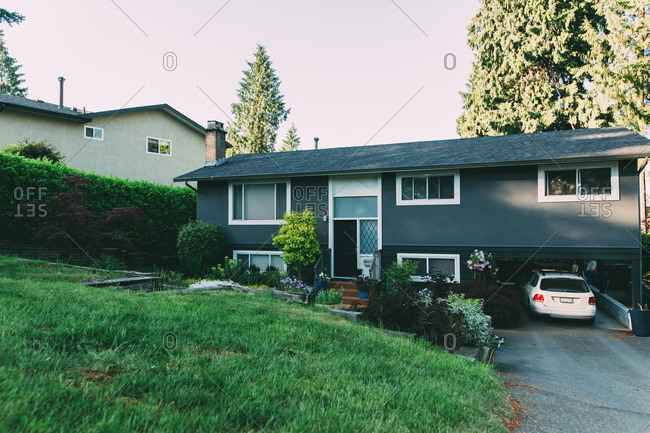

In [ ]:
img

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            # Upsampling
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Output layer
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
# Copyright 2020 Lorna Authors. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            # Upsampling
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Output layer
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels))

    def forward(self, x):
        return x + self.res(x)

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (
                self.epochs - self.decay_epochs)

In [ ]:
# class ImageDataset(Dataset):
#     def __init__(self, root, seasons=['summer','winter'], transform=None, unaligned=True):
#         self.transform = transform
#         self.unaligned = unaligned

#         self.files_A = sorted(glob.glob(os.path.join(root, seasons[0]) + "/*.jpg"))
#         self.files_B = sorted(glob.glob(os.path.join(root, seasons[1]) + "/*.jpg"))

#     def __getitem__(self, index):
#         rand_B = random.randint(0, len(self.files_B) - 1)
        
#         try:
#           item_A = Image.open(self.files_A[index % len(self.files_A)])
#           if item_A.mode != 'RGB':
#             item_A = item_A.convert('RGB')
#           item_A = self.transform(item_A)

#           if self.unaligned:
#               item_B = Image.open(self.files_B[rand_B])
#               if item_B.mode != 'RGB':
#                 item_B = item_B.convert('RGB')
#               item_B = self.transform(item_B)
#           else:
#               item_B = Image.open(self.files_B[index % len(self.files_B)])
#               if item_B.mode != 'RGB':
#                 item_B = item_B.convert('RGB')
#               item_B = self.transform(item_B)

#         except:
#           print('\n',self.files_A[index % len(self.files_A)])
#           print(self.files_B[rand_B])

#         return {"A": item_A, "B": item_B}

#     def __len__(self):
#         return max(len(self.files_A), len(self.files_B))

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, seasons=['winter','summer'], transform=None, unaligned=True):
        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, seasons[0]) + "/*.jpg"))
        self.files_B = sorted(glob.glob(os.path.join(root, seasons[1]) + "/*.jpg"))

        # self.images_A = [Image.open(x) for x in self.files_A]
        # self.images_B = [Image.open(x) for x in self.files_B]

        print('Loading A images')
        self.images_A = []
        for path in tqdm(self.files_A):
          tmp_img = Image.open(path)
          tmp_img = transforms.Resize(int(image_size * 1.12), Image.BICUBIC)(tmp_img)
          self.images_A.append(tmp_img)
          
        print('Loading B images')
        self.images_B = []
        for path in tqdm(self.files_B):
          tmp_img = Image.open(path)
          tmp_img = transforms.Resize(int(image_size * 1.12), Image.BICUBIC)(tmp_img)
          self.images_B.append(tmp_img)


    def __getitem__(self, index):
        rand_B = random.randint(0, len(self.images_B) - 1)
        
        item_A = self.images_A[index]
        if item_A.mode != 'RGB':
          item_A = item_A.convert('RGB')
        item_A = self.transform(item_A)

        if self.unaligned:
            item_B = self.images_B[rand_B]
        else:
            item_B = self.images_B[index % len(self.files_B)]

        if item_B.mode != 'RGB':
          item_B = item_B.convert('RGB')
        item_B = self.transform(item_B)

          # print('\n',self.files_A[index % len(self.files_A)])
          # print(self.files_B[rand_B])

        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
# training settings
lr = 0.0002
epochs = 200
decay_epochs = 100
print_freq = 100
image_size=128
load_epoch = 34
load_weights = True

In [ ]:
# Copyright 2020 Lorna Authors. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import itertools
import os
import random

import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

try:
    os.makedirs(outfolder)
except OSError:
    pass

try:
    os.makedirs(os.path.join(data_root, 'weights'))
except OSError:
    pass

seed=42
random.seed(seed)
torch.manual_seed(seed)

cudnn.benchmark = True

if torch.cuda.is_available():
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# Dataset
dataset = ImageDataset(root=os.path.join(data_src),
                       transform=transforms.Compose([
                          #  transforms.Resize(int(image_size * 1.12), Image.BICUBIC),
                           transforms.RandomCrop(image_size),
                           transforms.RandomHorizontalFlip(),
                           transforms.ColorJitter(brightness=.1, hue=.05),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                       unaligned=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=False)


try:
    os.makedirs(os.path.join(outfolder, "A",'real_samples'))
    os.makedirs(os.path.join(outfolder, "B",'real_samples'))
    os.makedirs(os.path.join(outfolder, "A",'fake_samples'))
    os.makedirs(os.path.join(outfolder, "B",'fake_samples'))
except OSError:
    pass

# create model
netG_A2B = Generator().to(device)
netG_B2A = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

if load_weights:
    print("WEIGHTS LOADED FROM EPOCH:", load_epoch)
    netG_A2B.load_state_dict(torch.load(f"{data_root}/weights/netG_A2B_epoch_{load_epoch}.pth"))
    netG_B2A.load_state_dict(torch.load(f"{data_root}/weights/netG_B2A_epoch_{load_epoch}.pth"))
    netD_A.load_state_dict(torch.load(f"{data_root}/weights/netD_A_epoch_{load_epoch}.pth"))
    netD_B.load_state_dict(torch.load(f"{data_root}/weights/netD_B_epoch_{load_epoch}.pth"))
    start_epoch = load_epoch
else:
    start_epoch = 0

# define loss function (adversarial_loss) and optimizer
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                               lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_lambda = DecayLR(epochs, 0, decay_epochs).step
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

g_losses = []
d_losses = []

identity_losses = []
gan_losses = []
cycle_losses = []

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()



for epoch in range(start_epoch, epochs):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, data in progress_bar:

        # get batch size data
        real_image_A = data["A"].to(device)
        real_image_B = data["B"].to(device)
        batch_size = real_image_A.size(0)

        # real data label is 1, fake data label is 0.
        real_label = torch.full((batch_size, 1), 1, device=device, dtype=torch.float32)
        fake_label = torch.full((batch_size, 1), 0, device=device, dtype=torch.float32)

        ##############################################
        # (1) Update G network: Generators A2B and B2A
        ##############################################

        # Set G_A and G_B's gradients to zero
        optimizer_G.zero_grad()

        # Identity loss
        # G_B2A(A) should equal A if real A is fed
        identity_image_A = netG_B2A(real_image_A)
        loss_identity_A = identity_loss(identity_image_A, real_image_A) * 5.0
        # G_A2B(B) should equal B if real B is fed
        identity_image_B = netG_A2B(real_image_B)
        loss_identity_B = identity_loss(identity_image_B, real_image_B) * 5.0

        # GAN loss
        # GAN loss D_A(G_A(A))
        fake_image_A = netG_B2A(real_image_B)
        fake_output_A = netD_A(fake_image_A)
        loss_GAN_B2A = adversarial_loss(fake_output_A, real_label)
        # GAN loss D_B(G_B(B))
        fake_image_B = netG_A2B(real_image_A)
        fake_output_B = netD_B(fake_image_B)
        loss_GAN_A2B = adversarial_loss(fake_output_B, real_label)

        # Cycle loss
        recovered_image_A = netG_B2A(fake_image_B)
        loss_cycle_ABA = cycle_loss(recovered_image_A, real_image_A) * 10.0

        recovered_image_B = netG_A2B(fake_image_A)
        loss_cycle_BAB = cycle_loss(recovered_image_B, real_image_B) * 10.0

        # Combined loss and calculate gradients
        errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB

        # Calculate gradients for G_A and G_B
        errG.backward()
        # Update G_A and G_B's weights
        optimizer_G.step()

        ##############################################
        # (2) Update D network: Discriminator A
        ##############################################

        # Set D_A gradients to zero
        optimizer_D_A.zero_grad()

        # Real A image loss
        real_output_A = netD_A(real_image_A)
        errD_real_A = adversarial_loss(real_output_A, real_label)

        # Fake A image loss
        fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
        fake_output_A = netD_A(fake_image_A.detach())
        errD_fake_A = adversarial_loss(fake_output_A, fake_label)

        # Combined loss and calculate gradients
        errD_A = (errD_real_A + errD_fake_A) / 2

        # Calculate gradients for D_A
        errD_A.backward()
        # Update D_A weights
        optimizer_D_A.step()

        ##############################################
        # (3) Update D network: Discriminator B
        ##############################################

        # Set D_B gradients to zero
        optimizer_D_B.zero_grad()

        # Real B image loss
        real_output_B = netD_B(real_image_B)
        errD_real_B = adversarial_loss(real_output_B, real_label)

        # Fake B image loss
        fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
        fake_output_B = netD_B(fake_image_B.detach())
        errD_fake_B = adversarial_loss(fake_output_B, fake_label)

        # Combined loss and calculate gradients
        errD_B = (errD_real_B + errD_fake_B) / 2

        # Calculate gradients for D_B
        errD_B.backward()
        # Update D_B weights
        optimizer_D_B.step()

        progress_bar.set_description(
            f"[{epoch}/{epochs - 1}][{i}/{len(dataloader) - 1}] "
            f"Loss_D: {(errD_A + errD_B).item():.4f} "
            f"Loss_G: {errG.item():.4f} "
            f"Loss_G_identity: {(loss_identity_A + loss_identity_B).item():.4f} "
            f"loss_G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f} "
            f"loss_G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}")

        if i % print_freq == 0:
            vutils.save_image(real_image_A,
                              f"{outfolder}/A/real_samples/epoch_{epoch}_{i}.png",
                              normalize=True)
            vutils.save_image(real_image_B,
                              f"{outfolder}/B/real_samples/epoch_{epoch}_{i}.png",
                              normalize=True)

            fake_image_A = 0.5 * (netG_B2A(real_image_B).data + 1.0)
            fake_image_B = 0.5 * (netG_A2B(real_image_A).data + 1.0)

            vutils.save_image(fake_image_A.detach(),
                              f"{outfolder}/A/fake_samples/epoch_{epoch}_{i}.png",
                              normalize=True)
            vutils.save_image(fake_image_B.detach(),
                              f"{outfolder}/B/fake_samples/epoch_{epoch}_{i}.png",
                              normalize=True)

    # do check pointing
    torch.save(netG_A2B.state_dict(), f"{data_root}/weights/netG_A2B_epoch_{epoch}.pth")
    torch.save(netG_B2A.state_dict(), f"{data_root}/weights/netG_B2A_epoch_{epoch}.pth")
    torch.save(netD_A.state_dict(), f"{data_root}/weights/netD_A_epoch_{epoch}.pth")
    torch.save(netD_B.state_dict(), f"{data_root}/weights/netD_B_epoch_{epoch}.pth")

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

# save last check pointing
torch.save(netG_A2B.state_dict(), f"{data_root}/weights/netG_A2B.pth")
torch.save(netG_B2A.state_dict(), f"{data_root}/weights/netG_B2A.pth")
torch.save(netD_A.state_dict(), f"{data_root}/weights/netD_A.pth")
torch.save(netD_B.state_dict(), f"{data_root}/weights/netD_B.pth")

Loading A images


  0%|          | 0/3575 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
100%|██████████| 3575/3575 [04:06<00:00, 14.52it/s]


Loading B images


100%|██████████| 2319/2319 [33:51<00:00,  1.14it/s]


WEIGHTS LOADED FROM EPOCH: 34


[34/199][1482/3574] Loss_D: 0.5348 Loss_G: 4.5435 Loss_G_identity: 1.1152 loss_G_GAN: 0.3514 loss_G_cycle: 3.0768:  41%|████▏     | 1483/3575 [05:23<06:07,  5.69it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
[34/199][3100/3574] Loss_D: 0.7656 Loss_G: 3.7746 Loss_G_identity: 0.8808 loss_G_GAN: 0.5978 loss_G_cycle: 2.2960:  87%|████████▋ | 3100/3575 [11:02<01:27,  5.43it/s]

In [ ]:
identity_image_A.shape, real_image_A.shape